# Connecting to Forecast Services via Virtual Private Cloud (VPC) Endpoints


We are excited to announce that Amazon Forecast is now integrated as an AWS service within AWS PrivateLink. Through this integration, you can now easily provision Amazon Forecast interface endpoints within your own Virtual Private Cloud (VPC) and create connections to Amazon Forecast without needing access to the public internet. This is beneficial to customers with strict security or network requirement that restricts them from sending data over public internet.

In addition, you can access additional access controls for services with VPC endpoints through usage of VPC endpoint policies, which will not override or replace the calling identity's IAM permissions, but be enforced in conjunction with the IAM permissions to allow additional control for the VPC owner. For example, if you want to only allow `ListDatasets` action when users within the VPC wants to hit Forecast service through the VPC endpoint, you can define a VPC endpoint policy such that only `ListDatasets` operation is allowed for all connections through the VPC endpoint, without the need of restricting each user's IAM permissions to do so. 

With today's launch, we are offering the following endpoint services for Amazon Forecast

1. A VPC endpoint service to use with Amazon Forecast operations. For most users, this is the most suitable type of VPC endpoint service to establish endpoint connections to.
  - `com.amazonaws.<region>.forecast`
  - `com.amazonaws.<region>.forecastquery`
1. A VPC endpoint service for Amazon Forecast operations with endpoints that comply with the Federal Information Processing Standard (FIPS) Publication 140-2 US government standard (availble in select regions only, see https://docs.aws.amazon.com/general/latest/gr/forecast.html for regions with support for FIPS endpoints)
  - `com.amazonaws.<region>.forecast-fips`
  - `com.amazonaws.<region>.forecastquery-fips`

In this guide, we provide a step-by-step guide on how to connect to Amazon Forecast via VPC endpoints. First, we will cover some terminology.


## Terminology

The following terminology is helpful for readers to understand what VPC related components are, and will aid reader with understanding the rest of the guide.

- **Private DNS**: This is a feature offered by VPC and AWS PrivateLink to allow users to easily provision changes to your own Route53 Private Hosted Zones to connect to an internal service or PrivateLink based services, including Amazon Forecast's PrivateLink enabled services. During this guide, we will showcase how to enable private DNS such that clients minimize code changes and still be able to call Forecast through VPC. More details about PrivateDNS at https://aws.amazon.com/about-aws/whats-new/2020/01/aws-privatelink-supports-private-dns-names-internal-3rd-party-services/
- **VPC**: A VPC (Virtual Private Cloud) is a logically isolated virtual network that allows you control the virtual networking environment. See https://aws.amazon.com/vpc/ for more details.
- **VPC Endpoint**: A VPC endpoint enables connections between a virtual private cloud (VPC) and supported services, without requiring that you use an internet gateway, NAT device, VPN connection, or AWS Direct Connect connection. We will be creating VPC endpoints to Amazon Forecast services within this guide. For more details on VPC endpoints, see https://docs.aws.amazon.com/vpc/latest/privatelink/vpc-endpoints.html
- **VPC Endpoint Policy**: A VPC endpoint policy is an IAM resource policy that you can attach to a VPC endpoint, and it allows you to control access to the service that you're connecting to. We will be exploring usage of the VPC endpoint policies in this guide. Fore more details on VPC endpoint policies, see https://docs.aws.amazon.com/vpc/latest/privatelink/vpc-endpoints-access.html. You can also see list of sample policies at https://docs.aws.amazon.com/forecast/latest/dg/vpc-interface-endpoints.html

## Overview of Guide

This guide is splitted into 2 parts.

Part 1 of this guide aims to walk the user through the VPC endpoint creation process, as well as setting up related infrastructure for testing purpose. Towards the end of this guide, you will have VPC endpoints available for connecting to Amazon Forecast services via VPC. You can use these VPC endpoints in various ways such as within Lambdas, EC2s, a SageMaker notebook, etc. 

Part 2 of this guide is available in Jupyter Notebook at https://github.com/aws-samples/amazon-forecast-samples/tree/main/notebooks/advanced/VPC_PrivateLink/Connect_Via_VPC_Endpoint_Guide.ipynb. The notebook will help reader understand how to configure AWS clients to connect to the VPC endpoints, what VPC endpoint policy can control, and how to verify that a call is going through VPC endpoint. Note that although we are connecting to Forecast through VPC via Jupyter notebook, you can do similar thing with compute resources inside a VPC such as Lambda, EC2, etc. The general concept of the notebook should still be applicable

Disclaimers:
- The configuration values used for creation of resources within this guide are for example purpose only. We strongly encourage you to read through the AWS docs to choose the right configuration values for production usage.
- Note that the screenshots used in the notebook may be slightly different depending on the console version, but the general instructions should still be applicable.


## Part 1: VPC Related Setup <a class="anchor" id="vpcrelatedsetup"></a>

We will be creating some VPC related resources such as VPC, and VPC endpoints to test VPC connections to Amazon Forecast's PrivateLink enabled services. The configuration values used for creation of these resources are for this sample guide purpose only. We strongly encourage you to read through the AWS docs to choose the right configuration values for production usage. If you have existing VPC/subnet/security groups you wish to use, feel free to do so as well.

We will also be creating resources in `us-west-2` region. But feel free to create the resources in any Forecast supported regions of your choosing, just be sure to use consistent region throughout the guide

### Create VPC

1. Go to AWS Console
1. Select the appropriate region on the top right (`us-west-2` for purpose of this guide)
1. Head to `VPC` console page
1. Click on `Your VPCs` on the left navigation panel
1. Click on `Create VPC`
1. For the purpose of the guide, we will be using the sample configuration values for the VPC below
  - Populate `Name tag` field with `private-link-test-vpc`
  - Choose `IPv4 CIDR maunal input` and populate CIDR block with `10.0.0.0/24`
  - Choose `No IPv6 CIDR block`
  - Choose Tenancy as `Default`
  - Your screen should look similar to ![Create VPC](./images/CreateVPC.png)
  - Click `Create VPC`
1. Wait till your VPC is in `available` state
1. The following step is only required if we are planning to enable PrivateDNS, which we do plan to do in this guide. Select the VPC you just created
  - Make sure `DNS hostnames` shows `Enabled`. If not, click `Actions`, click `Edit DNS hostnames`, make sure to check `Enable`, and click `Save changes`
  - Make sure `DNS resolution` shows `Enabled`. If not, click `Actions`, click `Edit DNS resolution`, make sure to check `Enable` and click `Save changes`

### Create Subnet

1. Head back to `VPC` console page
1. Click on `Subnets` on the left navigation panel
1. Click on `Create subnet`
1. For the purpose of this guide, we will be using the sample configuration values for the subnet below
  - Select the VPC tagged with `private-link-test-vpc` as the VPC to use under VPC ID
  - Populate `private-link-test-subnet-01` under `Subnet name`
  - Choose `us-west-2a` as the `Availability Zone`
  - Populate `10.0.0.0/24` as the `IPv4 CIDR block`
  - Your screen should look similar to ![Create Subnet](./images/CreateSubnet.png)
  - Click `Create subnet`
1. Wait till the subnet is in `available` state
1. Note that best practice is usually to create multiple subnets under multiple AZs, but for purpose of this guide, we will just be creating one subnet

### Create Security Group

1. Head back to `VPC` console page
1. Click on `Security Groups` on the left navigation panel
1. Click on `Create security group`
1. For the purpose of the guide, we will be using the sample configuration values for the security group below
  - Populate `private-link-test-securty-group` as the `Security group name`
  - Populate `Allow inbound and outbound HTTPS connections for private link testing purpose` in the `Description`
  - Be sure to select the right VPC ID corresponding to VPC tagged with `private-link-test-vpc`
  - Click `Add rule` under `Inbound rules`
    - Select `HTTPS` as `Type`
    - Select `Anywhere-IPv4` as the `Source`
  - Modify the rule under `Outbound rules`
    - Select `HTTPS` as `Type`
    - Select `Anywhere-IPv4` as the `Source`
  - Your screen should look similar to ![Create Security Group](./images/CreateSecurityGroup.png)
  - Click `Create security group`

### Create VPC endpoints

As of January 2022, you can create two types of Amazon VPC endpoints to use with Amazon Forecast:

1. A VPC endpoint to use with Amazon Forecast operations. For most users, this is the most suitable type of VPC endpoint.
  - `com.amazonaws.<region>.forecast`
  - `com.amazonaws.<region>.forecastquery`
1. A VPC endpoint for Amazon Forecast operations with endpoints that comply with the Federal Information Processing Standard (FIPS) Publication 140-2 US government standard (availble in select regions only, see https://docs.aws.amazon.com/general/latest/gr/forecast.html for regions with support for FIPS endpoints)
  - `com.amazonaws.<region>.forecast-fips`
  - `com.amazonaws.<region>.forecastquery-fips`
  
For the purpose of this guide, we will choose the most common and standard regular endpoints instead of the FIPS endpoints.

In the below steps, we will be creating the VPC endpoints that will be used for connecting traffic destined for the VPC to the Amazon Forecast services without going through the public internet.

1. Head back to `VPC` console page
1. Click on `Endpoints` on the left navigation panel
1. Click on `Create endpoint`
1. Create endpoint for `com.amazonaws.us-west-2.forecast` with values below
  - Select `AWS services` under `Service Category`
  - Under `Services`, populate the `Filter services` textbox with search term `forecast`
  - Select `com.amazonaws.us-west-2.forecast`
  - Under `VPC`, select the VPC ID corresponding to VPC tagged with `private-link-test-vpc`
  - Under `VPC`, expand the additional settings, be sure to uncheck `Enable DNS` name for now. This is to disable privateDNS support for now, we will enable it in later section of the guide
  - Under `Subnet`, select `us-west-2a` as the Availability Zone, and select the subnet id corresponding to `private-link-test-subnet-01`
  - Under `Security Groups`, select security group corresponding to `private-link-test-securty-group`
  - Under `Policy`, select `Custom` and add the following policy (we will change it to Full Access in later section):
    ```json
    {
        "Statement": [
            {
                "Principal": "*",
                "Effect": "Allow",
                "Action": [
                    "forecast:ListDatasets"
                ],
                "Resource": "*"
            }
        ]
    }
    ```
    - This custom policy will allow connections through the VPC endpoint with ListDatasets action. All other actions are not allowed.
    - We will change it to Full Access in later section of this guide
  - Your screen should look similar to ![Create Forecast Endpoint 1](./images/CreateForecastEndpoint1.png) and ![Create Forecast Endpoint 2](./images/CreateForecastEndpoint2.png)
  - Click `Create endpoint`
  - Select the endpoint you just created, and wait to use it until the status changes to `Available`
1. Repeat above steps but create endpoint for `com.amazonaws.us-west-2.forecast-query` with differences below
  - Select `com.amazonaws.us-west-2.forecast-query` as the service
  - Leave `Enable DNS` name checked to enable PrivateDNS support
  - Select `Full access` under `Policy` to allow Full access
  - Your screen should look similar to ![Create Forecast Query Endpoint](./images/CreateForecastQueryEndpoint.png)
  - Click `Create endpoint`
  - Select the endpoint you just created, and wait to use it until the status changes to `Available`

## Part 2: Demo Usage of VPC endpoints via Notebook

The VPC endpoints we created in steps above are now available for your usage. You can use these VPC endpoints in various ways such as within Lambdas, EC2s, a SageMaker notebook, etc. 

For the purpose of the guide, we have prepared a Jupyter Notebook to demonstrate the second part of this guide at https://github.com/aws-samples/amazon-forecast-samples/tree/main/notebooks/advanced/VPC_PrivateLink/Connect_Via_VPC_Endpoint_Guide.ipynb. The notebook will help reader understand how to configure AWS clients to connect to the VPC endpoints, what VPC endpoint policy can control, and how to verify that a call is going through VPC endpoint. Note that although we are connecting to Forecast through VPC via Jupyter notebook, you can do similar thing with compute resources inside a VPC such as Lambda, EC2, etc. The general concept of the notebook should still be applicable.

Please continue the guide through the Jupyter notebook

### Notebook Related Setup <a class="anchor" id="notebookrelatedsetup"></a>

#### Create Notebook Instance within VPC
We will be creating a new notebook instance within a VPC. Be sure to relaunch this jupyter notebook within the newly launched notebook instance afterwards

1. Go to AWS Console
1. Select the appropriate region on the top right (`us-west-2` for purpose of this guide)
1. Head to `Amazon SageMaker` console page
1. Clck `Notebook instances` under `Notebook` on left navigation panel
1. Click `Create notebook instance`
1. For the purpose of the guide, we will be using the sample configuration values for the security group below
  - Populate `private-link-test-notebook` under `Notebook instance name`
  - Select `ml.t2.medium` as `Notebook instance type`
  - Select `notebook-al2-v1` as the `Platform identifier`
  - Under IAM role, feel free to create role or reusing existing role, and restrict access if needed. For guide purpose, will proceed with `Any S3 bucket access`.
  - Expand `Network` tab
  - Select VPC ID corresponding to VPC tagged with `private-link-test-vpc`
  - Select Subnet corresponding to subnet tagged with `private-link-test-subnet-01`
  - Select Security Group corresponding to security group tagged with `private-link-test-security-group`
  - Select `Enable — Access the internet directly through Amazon SageMaker` since within notebook, we will need access to the git hub repository, S3, IAM, etc. Be sure to look at https://docs.aws.amazon.com/sagemaker/latest/dg/appendix-notebook-and-internet-access.html if you want to choose `Disable` to restrict the notebook to connect through VPC only. For purpose of this guide, we will choose `Enable` option.
  - Expand `Git repositories`
  - Select `Clone a public Git repository to this notebook isntance only`
  - Populate `https://github.com/aws-samples/amazon-forecast-samples.git` under `Git repository URL` to copy contents of https://github.com/aws-samples/amazon-forecast-samples
  - Your screen should look similar to ![Create Notebook Instance](./images/CreateNotebookInstance.png)
  - Click `Create notebook instance`
1. Wait for the notebook to be created and status updates to `InService`. If status is at `Stopped`, just select it, click `Actions`, and click `Start`
1. Click Open Jupyter
1. Navigate to this notebook under `notebooks -> advanced -> VPC_PrivateLink -> Connect_Via_VPC_Guide.ipynb`
1. Be sure you have relaunched this notebook under the Notebook instance created above


#### Setup the IAM permission for the SageMaker Role
1. Go to IAM console
1. Select the SageMaker role that was created above
1. Click `Add in-line policy` to attach a new in-line policy with the below JSON. Be sure to replace `<YOURACCOUNTID>` with your AWS account ID. You can name the in-line policy with something like `test-private-link-forecast-and-iam-policy`
```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "forecast:*"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:PassRole"
            ],
            "Resource": "arn:aws:iam::<YOURACCOUNTID>:role/ForecastNotebookRole-Basic",
            "Condition": {
                "StringEquals": {
                    "iam:PassedToService": "forecast.amazonaws.com"
                }
            }
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:CreateRole",
                "iam:GetRole"
            ],
            "Resource": "arn:aws:iam::<YOURACCOUNTID>:role/ForecastNotebookRole-Basic"
        }
    ]
}
```

### Familiarize Yourself with Forecast Quick Start Guide <a class="anchor" id="familiarizeyourself"></a>
This notebook assumes you have walked through the Forecast Quick Start Guide at https://github.com/aws-samples/amazon-forecast-samples/blob/main/notebooks/basic/Getting_Started/Amazon_Forecast_Quick_Start_Guide.ipynb and understand the general Forecast creation process. The Quick Start Guide notebook will walkthrough the detailed dataset creation, dataset importing, training of predictor, and generation of Forecast, which we will assume you have seen already through the rest of this guide.

If you have not done so, please go through the Quick Start Guide

### Environment Setup <a class="anchor" id="environmentsetup"></a>

#### Install necessary libraries (execute if necessary, such as if imports below fails)

In [11]:
# %%capture --no-stderr setup

# !pip install pandas s3fs matplotlib ipywidgets
# !pip install boto3 --upgrade
# !pip install tqdm

# %reload_ext autoreload

#### Setup Imports

In [2]:
import sys
import os
import shutil
import datetime

import pandas as pd
import numpy as np
import boto3

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 5.0)

#### Create a session within specified region

In [4]:
region = 'us-west-2'
session = boto3.Session(region_name=region)

#### Setup IAM Role used by Amazon Forecast to access your data

In [12]:
role_name = "ForecastNotebookRole-Basic"
print(f"Creating Role {role_name}...")
role_arn = util.get_or_create_iam_role( role_name = role_name )

# echo user inputs without account
print(f"Success! Created role = {role_arn.split('/')[1]}")

Creating Role ForecastNotebookRole-Basic...
The role ForecastNotebookRole-Basic already exists, skipping creation
Done.
Success! Created role = ForecastNotebookRole-Basic


#### Upload S3 file under unique bucket name

In [6]:
key="data/taxi-dec2017-jan2019.csv"

taxi_df = pd.read_csv(key, dtype = object, names=['timestamp','item_id','target_value'])

display(taxi_df.head(3))

bucket_name = input("\nEnter S3 bucket name for uploading the data and hit ENTER key:")
print(f"\nAttempting to upload the data to the S3 bucket '{bucket_name}' at key '{key}' ...")

s3 = session.resource('s3')
bucket = s3.Bucket(bucket_name)
if not bucket.creation_date:
    if region != "us-east-1":
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
    else:
        s3.create_bucket(Bucket=bucket_name)

s3.Bucket(bucket_name).Object(key).upload_file(key)
ts_s3_path = f"s3://{bucket_name}/{key}"

print(f"\nDone, the dataset is uploaded to S3 at {ts_s3_path}.")

,timestamp,item_id,target_value
0,2017-12-01 00:00:00,4,27
1,2017-12-01 00:00:00,7,36
2,2017-12-01 00:00:00,10,2



Enter S3 bucket name for uploading the data and hit ENTER key:private-link-test-s3-20220127

Attempting to upload the data to the S3 bucket 'private-link-test-s3-20220127' at key 'data/taxi-dec2017-jan2019.csv' ...

Done, the dataset is uploaded to S3 at s3://private-link-test-s3-20220127/data/taxi-dec2017-jan2019.csv.


### Testing Forecast APIs through VPC <a class="anchor" id="testingforecastapis"></a>

We will walk through testing of Forecast APIs through the VPC. Be sure to have the VPC setups in Part 1 completed.

#### Testing existing public DNS without VPC

Since we have not turned on privateDNS for the `com.amazonaws.us-west-2.forecast` VPC endpoint. The action below succceeds because we're using a sageMaker with internet access, and the connection is going through the non-VPC public DNS `forecast.us-west-2.amazonaws.com` to make connection to Forecast service

In [63]:
forecast = session.client(service_name='forecast')

In [64]:
forecast.list_predictors()

{'Predictors': [{'PredictorArn': 'arn:aws:forecast:us-west-2:282494629315:predictor/TAXI_PREDICTOR_01FTHF1KK7E6VVR676WVN24MXC',
   'PredictorName': 'TAXI_PREDICTOR',
   'DatasetGroupArn': 'arn:aws:forecast:us-west-2:282494629315:dataset-group/TAXI_DEMO_PRIVATE_LINK',
   'IsAutoPredictor': True,
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2022, 1, 28, 23, 6, 37, 563000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2022, 1, 31, 18, 42, 0, 881000, tzinfo=tzlocal())}],
 'ResponseMetadata': {'RequestId': '60fb2632-5fe1-405a-b322-89de9f20c586',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 31 Jan 2022 19:56:41 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '370',
   'connection': 'keep-alive',
   'x-amzn-requestid': '60fb2632-5fe1-405a-b322-89de9f20c586'},
  'RetryAttempts': 0}}

#### Testing new VPC specific endpoints

We will now start testing connection through a VPC endpoint.

Because we didn't enable privateDNS for the `com.amazonaws.us-west-2.forecast` VPC endpoint, we will have to go find the VPC specific DNS that the PrivateLink generated for us. You can find it by going to the VPC console, and clicking the VPC endpoint we just created for `com.amazonaws.us-west-2.forecast`. Locate the DNS under section similar to ![VPC specific DNS](./images/VpcSpecificDNS.png)

The DNS is VPC endpoint specific, so the one in this guide will not be completely same as yours, but it should be similar. 

Populate the DNS below with prefix `https://`

In [17]:
# With non-private VPC DNS
forecast_dns = "https://vpce-0e328db54a7a149fa-j82j07dz.forecast.us-west-2.vpce.amazonaws.com";

In [20]:
forecast = session.client(service_name='forecast',
    region_name=region,
    endpoint_url=forecast_dns
)

**Explain**

The call below is expected to fail because the VPCE policy that we defined above only allows `ListDatasets` action. However, since we know VPCE policy is only attached to the VPC endpoint, we can assure ourselves that the call is going through the VPC endpoint. What we learned is a simple way of checking that we are making network calls through the VPC endpoint

In [28]:
forecast.list_predictors()

ClientError: An error occurred (AccessDeniedException) when calling the ListPredictors operation: User: arn:aws:sts::282494629315:assumed-role/AmazonSageMaker-ExecutionRole-20220127T153361/SageMaker is not authorized to perform: forecast:ListPredictors because no VPC endpoint policy allows the forecast:ListPredictors action

We can do a `ListDatasets` action to verify that we are able to make successful through the VPC endpoint

In [29]:
forecast.list_datasets()

{'Datasets': [],
 'ResponseMetadata': {'RequestId': '98113a60-5d94-4b1e-abb0-67d46c771d17',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 28 Jan 2022 22:38:04 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '15',
   'connection': 'keep-alive',
   'x-amzn-requestid': '98113a60-5d94-4b1e-abb0-67d46c771d17'},
  'RetryAttempts': 0}}

#### Testing VPC endpoint through PrivateDNS

Now we can test private DNS as well by enabling private DNS for `com.amazonaws.us-west-2.forecast` as well

1. Go to VPC console page
1. Click `Endpoints` on the left navigation panel
1. Select the VPC endpoint we created for `com.amazonaws.us-west-2.forecast`
1. Click `Actions` -> `Modify private DNS name`
1. Checkmark `Enable for this endpoint`
1. Click `Save changes`
1. You can wait till status becomes `Available`, and you should see the private DNS name listed under `Private DNS names`, with something similar to `forecast.<region>.us-west-2.amazonaws.com`

Note that the private DNS name is simliar to the public DNS name for our public endpoints at https://alpha-docs-aws.amazon.com/general/latest/gr/forecast.html#forecast_region. This means that for existing clients already calling us, if you create the VPC endpoint within the same VPC and enable private DNS, you shouldn't have to make much code change afterwards.

We will test this below where we initialize the standard forecast client that points to the public DNS which resolves to the private DNS and resolves to the VPC endpoint.

In [30]:
forecast = session.client(service_name='forecast')

In [31]:
forecast.list_predictors()

ClientError: An error occurred (AccessDeniedException) when calling the ListPredictors operation: User: arn:aws:sts::282494629315:assumed-role/AmazonSageMaker-ExecutionRole-20220127T153361/SageMaker is not authorized to perform: forecast:ListPredictors because no VPC endpoint policy allows the forecast:ListPredictors action

In [32]:
forecast.list_datasets()

{'Datasets': [],
 'ResponseMetadata': {'RequestId': 'aa280a6a-3a45-42ef-9cad-18bc03ac3e1a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 28 Jan 2022 22:43:32 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '15',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'aa280a6a-3a45-42ef-9cad-18bc03ac3e1a'},
  'RetryAttempts': 0}}

#### Restoring full access policy

From above, we can see that the VPCE policy is still being applied, so we learned that we are now making connections through the VPC endpoint.

VPC endpoint policy can be useful since it's applied in conjunction with the calling identity's IAM permissions. For example, if you want to restrict all calls to only `ListDatasets` for all calls through the VPC endpoint, you can do so via the VPC endpoint policy instead of having to restrict each user's IAM permission. Of course, the best practice is to restrict user's IAM permission down to only what's needed though.

Since we have seen how VPC endpoint policies work, let's restore the policy back to full access now for the rest of the notebook. Note that you can customize the VPC endpoint policy, and we have some example policies listed at https://docs.aws.amazon.com/forecast/latest/dg/vpc-interface-endpoints.html

1. Go to VPC console page
1. Click `Endpoints` on the left navigation panel
1. Select the VPC endpoint we created for `com.amazonaws.us-west-2.forecast`
1. Click on the `Policy` tab
1. Click `Edit Policy`
1. Select `Full access`
1. Click `Save`
1. It takes a few minutes for the policy to update. But you should be able to execute any Forecast APIs afterwards

In [34]:
forecast.list_predictors()

{'Predictors': [],
 'ResponseMetadata': {'RequestId': '44aa99c1-c765-4a96-adfc-b487b6da578b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 28 Jan 2022 22:49:59 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '17',
   'connection': 'keep-alive',
   'x-amzn-requestid': '44aa99c1-c765-4a96-adfc-b487b6da578b'},
  'RetryAttempts': 0}}

## Conclusion

Through this guide, we learned how to create VPC endpoints through Amazon Forecast's integration with VPC PrivateLink, as well as how to connect to Amazon Forecast services using these VPC endpoints via [Notebook](https://github.com/aws-samples/amazon-forecast-samples/tree/main/notebooks/advanced/VPC_PrivateLink/Connect_Via_VPC_Endpoint_Guide.ipynb). We also learned what VPC endpoint policies are, and how to configure VPC endpoint policies to verify that API calls are going through the VPC endpoints. Through VPC endpoints, you can now connect to Amazon Forecast services through these endpoints without having to connect through public internet.

To learn more, review [Forecast and Interface VPC endpoints](https://docs.aws.amazon.com/forecast/latest/dg/vpc-interface-endpoints.html). All these new capabilities are available in all Regions where Forecast is publicly available. For more information about Region availability, see [Amazon Forecast endpoints and quotas](https://alpha-docs-aws.amazon.com/general/latest/gr/forecast.html#forecast_region)


## Bonus: Walking through Forecast Creation <a class="anchor" id="walkthroughbasic"></a>

For the rest of this notebook, we will be just revisiting the Forecast creation steps within the Forecast Quick Start Guide, just to show that the API calls are successful even inside VPC.

However, if you want more explanations, please look at https://github.com/aws-samples/amazon-forecast-samples/blob/main/notebooks/basic/Getting_Started/Amazon_Forecast_Quick_Start_Guide.ipynb

#### Creating the Dataset

In [35]:
DATASET_FREQUENCY = "H" # H for hourly.
TS_DATASET_NAME = "TAXI_TS_PRIVATE_LINK"
TS_SCHEMA = {
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"integer"
      }
   ]
}

create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                  DatasetType='TARGET_TIME_SERIES',
                                                  DatasetName=TS_DATASET_NAME,
                                                  DataFrequency=DATASET_FREQUENCY,
                                                  Schema=TS_SCHEMA)

ts_dataset_arn = create_dataset_response['DatasetArn']
describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn)

print(f"The Dataset with ARN {ts_dataset_arn} is now {describe_dataset_response['Status']}.")

The Dataset with ARN arn:aws:forecast:us-west-2:282494629315:dataset/TAXI_TS_PRIVATE_LINK is now ACTIVE.


#### Importing the Dataset

In [39]:
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"
TS_IMPORT_JOB_NAME = "TAXI_TTS_IMPORT_PRIVATE_LINK"
TIMEZONE = "EST"

ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=TS_IMPORT_JOB_NAME,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT,
                                       TimeZone = TIMEZONE)

ts_dataset_import_job_arn = ts_dataset_import_job_response['DatasetImportJobArn']
describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)

print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn} to become ACTIVE. This process could take 5-10 minutes.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))

describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)
print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn} is now {describe_dataset_import_job_response['Status']}.")

Waiting for Dataset Import Job with ARN arn:aws:forecast:us-west-2:282494629315:dataset-import-job/TAXI_TS_PRIVATE_LINK/TAXI_TTS_IMPORT_PRIVATE_LINK to become ACTIVE. This process could take 5-10 minutes.

Current Status:
CREATE_PENDING .
CREATE_IN_PROGRESS ....................................
ACTIVE 


The Dataset Import Job with ARN arn:aws:forecast:us-west-2:282494629315:dataset-import-job/TAXI_TS_PRIVATE_LINK/TAXI_TTS_IMPORT_PRIVATE_LINK is now ACTIVE.


#### Creating a DatasetGroup

In [40]:
DATASET_GROUP_NAME = "TAXI_DEMO_PRIVATE_LINK"
DATASET_ARNS = [ts_dataset_arn]

create_dataset_group_response = \
    forecast.create_dataset_group(Domain="CUSTOM",
                                  DatasetGroupName=DATASET_GROUP_NAME,
                                  DatasetArns=DATASET_ARNS)

dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
describe_dataset_group_response = forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

print(f"The DatasetGroup with ARN {dataset_group_arn} is now {describe_dataset_group_response['Status']}.")

The DatasetGroup with ARN arn:aws:forecast:us-west-2:282494629315:dataset-group/TAXI_DEMO_PRIVATE_LINK is now ACTIVE.


#### Train a predictor

In [ ]:
PREDICTOR_NAME = "TAXI_PREDICTOR"
FORECAST_HORIZON = 24
FORECAST_FREQUENCY = "H"
HOLIDAY_DATASET = [{
        'Name': 'holiday',
        'Configuration': {
        'CountryCode': ['US']
    }
}]

create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = PREDICTOR_NAME,
                                   ForecastHorizon = FORECAST_HORIZON,
                                   ForecastFrequency = FORECAST_FREQUENCY,
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn, 
                                       'AdditionalDatasets': HOLIDAY_DATASET
                                    },
                                   ExplainPredictor = True)

predictor_arn = create_auto_predictor_response['PredictorArn']
print(f"Waiting for Predictor with ARN {predictor_arn} to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn))

describe_auto_predictor_response = forecast.describe_auto_predictor(PredictorArn=predictor_arn)
print(f"\n\nThe Predictor with ARN {predictor_arn} is now {describe_auto_predictor_response['Status']}.")

Waiting for Predictor with ARN arn:aws:forecast:us-west-2:282494629315:predictor/TAXI_PREDICTOR_01FTHF1KK7E6VVR676WVN24MXC to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.

Current Status:
CREATE_PENDING ..
CREATE_IN_PROGRESS ................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [46]:
status = util.wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn))

describe_auto_predictor_response = forecast.describe_auto_predictor(PredictorArn=predictor_arn)
print(f"\n\nThe Predictor with ARN {predictor_arn} is now {describe_auto_predictor_response['Status']}.")

ACTIVE 


The Predictor with ARN arn:aws:forecast:us-west-2:282494629315:predictor/TAXI_PREDICTOR_01FTHF1KK7E6VVR676WVN24MXC is now ACTIVE.


#### Generate forecasts

In [50]:
FORECAST_NAME = "TAXI_FORECAST_PRIVATE_LINK"

create_forecast_response = \
    forecast.create_forecast(ForecastName=FORECAST_NAME,
                             PredictorArn=predictor_arn)

forecast_arn = create_forecast_response['ForecastArn']
print(f"Waiting for Forecast with ARN {forecast_arn} to become ACTIVE. Depending on data size and predictor settings，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn))

describe_forecast_response = forecast.describe_forecast(ForecastArn=forecast_arn)
print(f"\n\nThe Forecast with ARN {forecast_arn} is now {describe_forecast_response['Status']}.")

Waiting for Forecast with ARN arn:aws:forecast:us-west-2:282494629315:forecast/TAXI_FORECAST_PRIVATE_LINK to become ACTIVE. Depending on data size and predictor settings，it can take several hours to be ACTIVE.

Current Status:
CREATE_PENDING 
CREATE_IN_PROGRESS ..............................................................................................
ACTIVE 


The Forecast with ARN arn:aws:forecast:us-west-2:282494629315:forecast/TAXI_FORECAST_PRIVATE_LINK is now ACTIVE.


#### Load ground truth for pick-up location 48 on February 1, 2019.

In [51]:
ITEM_ID = "48"

taxi_feb_df = pd.read_csv("data/taxi-feb2019.csv", dtype = object, names=['timestamp','item_id','target_value'])
taxi_feb_df.target_value = taxi_feb_df.target_value.astype(float)

actuals = taxi_feb_df[(taxi_feb_df['item_id'] == ITEM_ID)]

#### Query forecasts for pick-up location 48 on February 1, 2019.

In [56]:
# Creating client that has privateDNS enabled, so still going through VPC
forecastquery = session.client(service_name='forecastquery')

In [57]:
forecast_response = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": ITEM_ID}
)

In [58]:

forecasts_p10_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
forecasts_p50_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
forecasts_p90_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])

#### Compare the forecasts with ground truth

In [60]:
import dateutil

<AxesSubplot:xlabel='timestamp'>

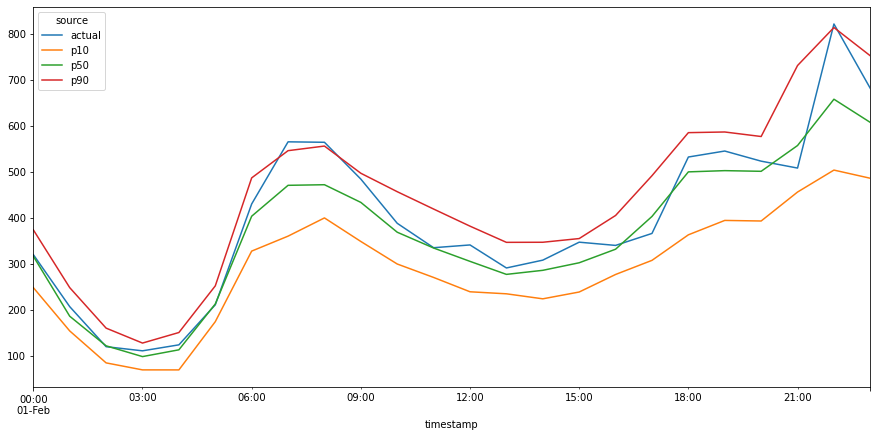

In [61]:
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

for index, row in actuals.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} , ignore_index=True)
for index, row in forecasts_p10_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in forecasts_p50_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in forecasts_p90_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df.plot(figsize=(15, 7))

* **Impact scores** measure the relative impact attributes have on forecast values. For example, if the holiday attribute has an impact score that is twice as large as another possible attribute, say weather, you can conclude that the holiday has twice the impact on forecast values than the weather. 
* **Impact scores** also provide information on whether an attribute increases or decreases the forecasted value. A negative impact scores reflects that the attribute tends to decrease the value of the forecast.

## Clean-up <a class="anchor" id="cleanup"></a>
Uncomment the code section to delete all resources that were created in this notebook.

In [62]:
# forecast.delete_resource_tree(ResourceArn = dataset_group_arn)
# forecast.delete_resource_tree(ResourceArn = ts_dataset_arn)

Be sure to also manually delete the following resources that we created

- VPC endpoints
- Notebook instance
- Notebook instance role
- VPC
- Subnet
- Security Group
